In [18]:
import torch,torchvision
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder




In [19]:
def toy_data(sample = 10000):
    colors = ['red','green','blue','yellow','purple','orange','black','white']
    shapes = ['circle','square','triangle']
    data = []
    labels = []

    for _ in range(sample):
        color = np.random.choice(colors)
        shape = np.random.choice(shapes)
        label = f"{color} {shape}"

        #creating the image
        img = Image.new('RGB',(64,64),'white')
        draw = ImageDraw.Draw(img)
        if shape == 'circle':
            draw.ellipse((10,10,54,54),fill = color)
        elif shape == 'square':
            draw.rectangle((10,10,54,54),fill = color)
        elif shape == 'triangle':
            draw.polygon([(32,16),(16,48),(48,48)], fill = color)

        data.append(np.array(img))
        labels.append(label)
    return np.array(data),labels

#generating the data
images,lables = toy_data()




        

In [20]:
#text-embedding
def text_embedding(labels):
    label_encoder = LabelEncoder()
    int_encoded = label_encoder.fit_transform(labels)
    one_hot_encoder = OneHotEncoder(sparse_output = False)
    int_encoded = int_encoded.reshape(len(int_encoded),1)
    onehot_encoded = one_hot_encoder.fit_transform(int_encoded)
    return onehot_encoded,label_encoder
    
text_embeddings,label_encoder = text_embedding(lables)


In [21]:
#BUILDING GAN
from torch import nn as nn
class Generator(nn.Module):
    def __init__(self,noise_dim,text_dim,img_channels):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim+text_dim,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,img_channels*64*64),
            nn.Tanh()  
        )

    def forward(self,noise,text_embedding):
        x = torch.cat((noise,text_embedding),dim = 1)
        x = self.model(x)
        return x.view(x.size(0),3,64,64)
    
noise_dim = 100
text_dim = text_embeddings.shape[1]
img_channels = 3
generator = Generator(noise_dim,text_dim,img_channels)




In [22]:
#discriminator
'''The discriminator takes an image and text embedding and outputs whether the image is real or fake.'''

class Discriminator(nn.Module):
    def __init__(self, img_channels, text_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(text_dim + img_channels * 64 * 64, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img, text_embedding):
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, text_embedding), dim=1)
        return self.model(x)
    
discriminator = Discriminator(img_channels, text_dim)
    
    

In [23]:
#loss and optimisers
from torch import optim
criterion = nn.BCELoss()
optimiser_G = optim.Adam(generator.parameters(),lr = 0.0002,betas = (0.5,0.999))
optimiser_D = optim.Adam(discriminator.parameters(),lr = 0.0002,betas = (0.5,0.999))


In [38]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming images and text_embeddings are already defined
img = torch.tensor(images.transpose((0, 3, 1, 2)) / 255.0, dtype=torch.float32)
text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)

# Building dataloader
dataset = TensorDataset(img, text_embeddings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

epochs = 100
noise_dim = 100

# Start timing
start_time = time.time()

for epoch in range(epochs):
    for imgs, text_embeds in dataloader:
        batch_size = imgs.size(0)
        valid = torch.ones((batch_size, 1), requires_grad=False)
        fake = torch.zeros((batch_size, 1), requires_grad=False)

        # Train Generator
        optimiser_G.zero_grad()
        noise = torch.randn(batch_size, noise_dim)
        gen_imgs = generator(noise, text_embeds)
        validity = discriminator(gen_imgs, text_embeds)
        g_loss = criterion(validity, valid)
        g_loss.backward()
        optimiser_G.step()

        # Train Discriminator
        optimiser_D.zero_grad()
        real_validity = discriminator(imgs, text_embeds)
        fake_validity = discriminator(gen_imgs.detach(), text_embeds)
        d_loss_real = criterion(real_validity, valid)
        d_loss_fake = criterion(fake_validity, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimiser_D.step()

        # Log progress
        if epoch % 100 == 0:
            print(f"epoch: {epoch} d_loss: {d_loss.item()} g_loss: {g_loss.item()}")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to train: {elapsed_time:.2f} seconds")

C:\Users\Aditya Dwaraki Rao\AppData\Local\Temp\ipykernel_7468\1682171221.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)


epoch: 0 d_loss: 0.19758474826812744 g_loss: 3.2218704223632812
epoch: 0 d_loss: 0.16118809580802917 g_loss: 3.480527877807617
epoch: 0 d_loss: 0.13846085965633392 g_loss: 3.4400172233581543
epoch: 0 d_loss: 0.17319583892822266 g_loss: 2.882667064666748
epoch: 0 d_loss: 0.21675768494606018 g_loss: 4.376338481903076
epoch: 0 d_loss: 0.23685720562934875 g_loss: 2.0432870388031006
epoch: 0 d_loss: 0.15882501006126404 g_loss: 3.8982057571411133
epoch: 0 d_loss: 0.2312975525856018 g_loss: 2.3865952491760254
epoch: 0 d_loss: 0.20137453079223633 g_loss: 4.6598968505859375
epoch: 0 d_loss: 0.3613818287849426 g_loss: 1.887681007385254
epoch: 0 d_loss: 0.17542847990989685 g_loss: 4.087129592895508
epoch: 0 d_loss: 0.13265255093574524 g_loss: 4.240340709686279
epoch: 0 d_loss: 0.18434107303619385 g_loss: 2.4663941860198975
epoch: 0 d_loss: 0.22231820225715637 g_loss: 3.399439573287964
epoch: 0 d_loss: 0.20933988690376282 g_loss: 3.637470245361328
epoch: 0 d_loss: 0.128637433052063 g_loss: 2.97405

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


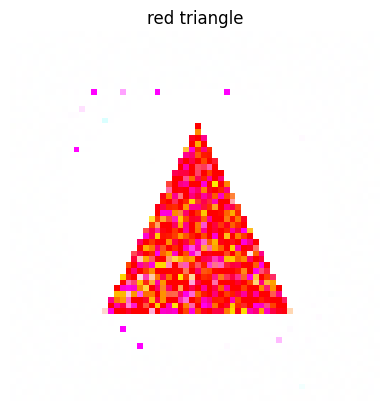

In [45]:
#genrating images
def generate_image(text,label_encoder):
    noise = torch.randn(1, noise_dim)
    text_embed = torch.tensor(label_encoder.transform([text]), dtype=torch.float32)
    text_embed = text_embeddings[text_embed.long()].squeeze(0)  # Get one-hot encoding
    text_embed = text_embed.unsqueeze(0)  # Add batch dimension
    
    # Set the generator to evaluation mode
    generator.eval()
    
    with torch.no_grad():
        gen_img = generator(noise, text_embed).detach().numpy()
    
    gen_img = gen_img.transpose((0, 2, 3, 1))
    plt.imshow(gen_img[0])
    plt.title(text)
    plt.axis("off")
    plt.show()

#exmple
generate_image("red triangle", label_encoder)


    